In [1]:
from nltk.corpus import brown
import nltk
from nltk.probability import FreqDist

from pprint import pprint
nltk.download('brown')
from nltk.util import ngrams
from collections import Counter, defaultdict
import math

from nltk import word_tokenize

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [354]:
class LangModel():
    
    def __init__(self,corpus):
        self.corpus=corpus
        self.vocab=None
        self.fd=None
        self.numgrams=[]
    
#calc stats such as fd and vocab        
    def calcStats(self):
        textCorpus = nltk.Text(self.corpus.words(self.corpus.fileids()))
        textFD = FreqDist(t.lower() for t in textCorpus)
        vocab=list(textFD.keys())
        unkcount=0
        for key in vocab:
            if(textFD[key]==1):
                unkcount=unkcount+1
        vocab.append("unk")
        textFD["unk"]=unkcount
        self.fd=textFD
        self.vocab=vocab
        self.numNgrams()
        return
        
#to display collocations       
    def collocations(self,topn):
        #corpus is brown by default
        n = 2
        bigrams = ngrams(self.corpus.words(), n)
        brownNgramFD = nltk.FreqDist(token for token in bigrams)
        brownNgramFD.plot(topn)
        return

#calc the number of ngrams
    def numNgrams(self):
#         n = 2
        for i in range(2,6):
            n_grams = ngrams(self.corpus.words(), i)
            NgramFD = nltk.FreqDist(token for token in n_grams)
            self.numgrams.append(len(NgramFD))
        return

#make a ngram model with or without add 1
    def makeModel(self,n,add1=False):
        # Create a placeholder for model
        model = defaultdict(lambda: defaultdict(lambda: 0))
        # Count frequency of co-occurance 
        data=brown.sents()
        for sentence in data:
            for it in range(len(sentence)):
                sentence[it]=sentence[it].lower()
            for n_grams in ngrams(sentence,n):#pad_right=True, pad_left=True,):
                pre=n_grams[0:-1]
                post=n_grams[-1]
                model[pre][post] += 1
                model[pre]["unseen"]=0
        # Let's transform the counts to probabilities
        total=0
        unkcount=0
        extend=0
        if(add1):
            if(n==2):
                extend=len(self.vocab)
            if(n==3):
                extend=self.numgrams[0]
            if(n==4):
                extend=self.numgrams[1]
            if(n==5):
                extend=self.numgrams[2]
        print("extended value: ",extend)
        for wprev in model:
#             total_count = float(sum(model[wprev].values()))
            total_count=len(model[wprev])
#             total=total+total_count
            for wcurr in model[wprev]:
#                 if(model[wprev][wcurr]==1):
#                     unkcount+=1               
                if(add1):
                    model[wprev][wcurr]+=1
                    total_count+=extend
                    model[wprev]["unseen"]=1
                else:
                    model[wprev]["unseen"]=0
                model[wprev][wcurr] /= total_count

        return model
    
#make a language model with gte smoothing
    def makeGTmodel(self,n):
        # Create a placeholder for model
        model = defaultdict(lambda: defaultdict(lambda: 0))
        # Count frequency of co-occurance 
        data=brown.sents()
        for sentence in data:
            for it in range(len(sentence)):
                sentence[it]=sentence[it].lower()
            for n_grams in ngrams(sentence,n):#pad_right=True, pad_left=True,):
                pre=n_grams[0:-1]
                post=n_grams[-1]
                model[pre][post] += 1
                model[pre]["unseen"]=0
        # Let's transform the counts to probabilities
        
        for wprev in model:
#             total_count = float(sum(model[wprev].values()))
            total_count=len(model[wprev])
#             total=total+total_count
            counts=defaultdict(lambda: 0)
            for wcurr in model[wprev]:
                counts[model[wprev][wcurr]]+=1
            for wcurr in model[wprev]:
                if(counts[model[wprev][wcurr]]!=0):
                    model[wprev][wcurr]=((model[wprev][wcurr]+1)*counts[model[wprev][wcurr]+1]/counts[model[wprev][wcurr]])/total_count
                else:
                    model[wprev][wcurr]=counts[1]/total_count
#                 if(model[wprev][wcurr]==1):
#                     unkcount+=1               
#         
        return model

#work in progress KND   
    def KneserNeyDiscountingModel(self,n):
         # Create a placeholder for model
        model = defaultdict(lambda: defaultdict(lambda: 0))
        # Count frequency of co-occurance 
        data=brown.sents()
        for sentence in data:
            for it in range(len(sentence)):
                sentence[it]=sentence[it].lower()
            for n_grams in ngrams(sentence,n):#pad_right=True, pad_left=True,):
                pre=n_grams[0:-1]
                post=n_grams[-1]
                model[pre][post] += 1
                model[pre]["unseen"]=0
        # Let's transform the counts to probabilities
        
        for wprev in model:
#             total_count = float(sum(model[wprev].values()))
            total_count=len(model[wprev])
#             total=total+total_count
            counts=defaultdict(lambda: 0)
            for wcurr in model[wprev]:
                counts[model[wprev][wcurr]]+=1
            for wcurr in model[wprev]:
                if(counts[model[wprev][wcurr]]!=0):
                    model[wprev][wcurr]=((model[wprev][wcurr]+1)*counts[model[wprev][wcurr]+1]/counts[model[wprev][wcurr]])/total_count
                else:
                    model[wprev][wcurr]=counts[1]/total_count
#                 if(model[wprev][wcurr]==1):
#                     unkcount+=1               
#         
        return model
        

#generate sentences with the trained model
    def sentGen(self,start,n,model):
#         model=models[n-2]
        count=0
#         para=start.split()
        start=start.lower()
        para=nltk.word_tokenize(start)
        
        finalpara=start
        prob=1;
        MaxKey=" "
        while(MaxKey!="." and count<30):
            if(n==2):
                pos=dict(model[para[-1],])
            if(n==3):
                pos=dict(model[para[-2],para[-1]])
            if(n==4):
                pos=dict(model[para[-3],para[-2],para[-1]])
            if(n==5):
                pos=dict(model[para[-4],para[-3],para[-2],para[-1]])
            try:
        #        
                MaxKey = max(pos, key=pos.get)
                prob=prob*pos[MaxKey]
                para.append(MaxKey)
    #             if(n==2):
    #                 print(MaxKey)
            except:
                pass
            try:
                finalpara=finalpara+" "+MaxKey
            except TypeError:
                pass
            count=count+1

        print("\n"+finalpara)
        print("prob : ",prob)
        logprob=math.log(prob,2)
        print("logprob : ",logprob)
        perp=1/((1/count)*prob)
        perplog=math.pow(2,1/((1/count)*logprob))
        print("reg perp : ",perp)
        print("log perp : ",perplog)
        return
    
#find prob of a sentence given a trained model   
    def sentProb(self,sent,n,model,printprob=False):
#         para=sent.split()
#         print(para)
        sent=sent.lower()
        para=nltk.word_tokenize(sent)
        paralen=len(para)
        
        for i in range(paralen):
            if para[i] not in self.vocab:
                para[i]="unk"
        i=0
        prob=1
        prob1=0
        avgprob=0
        count=0
        sentprob=[]
        while(i<(paralen-(n-1))):
            if(n==2):
                prob1=model[para[i],][para[i+1]]
#                 print(para[i],para[i+1],prob1)
                if(prob1==0):
                    prob1=model[para[i],]["unseen"]
            if(n==3):
                prob1=model[para[i],para[i+1]][para[i+2]]
                if(prob1==0):
                    prob1=model[para[i],para[i+1]]["unseen"]
            if(n==4):
                prob1=model[para[i],para[i+1],para[i+2]][para[i+3]]
                if(prob1==0):
                    prob1=model[para[i],para[i+1],para[i+2]]["unseen"]
            if(n==5):
                prob1=model[para[i],para[i+1],para[i+2],para[i+3]][para[i+4]]
                if(prob1==0):
                    prob1=model[para[i],para[i+1],para[i+2],para[i+3]]["unseen"]

            prob*=prob1
            if(printprob):
                print("prob :",prob)

            if(para[i+n-1]=="."):
#             if(i%20==0):
                sentprob.append(prob)
#                 print("prob each sentence : ",prob)
#                 print("prob at "+str(i)+"th"+" ngram : ",prob)
                avgprob=avgprob+prob
                prob=1
                count=count+1
            
            i=i+1
        avgprob=avgprob/count
        print("sent probs : ",sentprob)
        if(avgprob==0):
            print("Average Prob of sent : 0")
        else:
            print("avgprob : ",avgprob)
            logprob=math.log(avgprob,2)
            print("logprob : ",logprob)
            perp=paralen/(avgprob)
            perplog=math.pow(2,(1/((1/paralen)*logprob)))
            print("reg perp : ",perp)
            print("log perp : ",perplog)
        return

In [355]:
lm=LangModel(brown)

In [356]:
lm.calcStats()

# FREQUENCY DISTRIBUTION

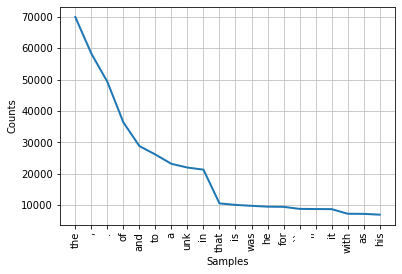

In [294]:
lm.fd.plot(20)

# NUM OF N-GRAMS

In [390]:
# print(lm.numgrams)
for i in range(len(lm.numgrams)):
    print("num of "+str(i+2)+" grams :"+str(lm.numgrams[i]))



num of 2 grams :455267
num of 3 grams :907494
num of 4 grams :1096987
num of 5 grams :1144405


# COLLOCATIONS 

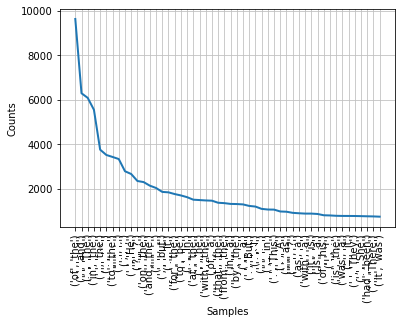

In [279]:
lm.collocations(50)

# MODEL GENERATION

In [315]:
bimodeladd1=lm.makeModel(2,add1=True)
bimodel=lm.makeModel(2)
bimodelgt=lm.makeGTmodel(2)

extended value:  49816
extended value:  0


In [368]:
trimodel=lm.makeModel(3)
trimodeladd1=lm.makeModel(3,add1=True)
trimodelgt=lm.makeGTmodel(3)

extended value:  0
extended value:  455267


In [369]:
quadmodeladd1=lm.makeModel(4,add1=True)
quadmodel=lm.makeModel(4)
quadmodelgt=lm.makeGTmodel(4)

extended value:  907494
extended value:  0


In [375]:
pentmodeladd1=lm.makeModel(5,add1=True)
pentmodel=lm.makeModel(5)
pentmodelgt=lm.makeGTmodel(5)

extended value:  1096987
extended value:  0


# SENTENCE GENERATION

In [378]:
lm.sentGen("A year ago today",5,pentmodel)
lm.sentGen("A year ago",4,quadmodel)
lm.sentGen("A year",3,trimodel)
lm.sentGen("I",2,bimodel)


a year ago today , when the democrats were fretting and frolicking in los angeles and john f. kennedy .
prob :  1.0172526041666666e-05
logprob :  -16.584962500721158
reg perp :  1572864.0
log perp :  0.5123745261007371

a year ago , when a reporter was standing near mantle's locker , mickey walked up and volunteered an anecdote .
prob :  1.507040895061728e-07
logprob :  -22.661778097771986
reg perp :  119439360.00000004
log perp :  0.5766273000079152

a year , and the other hand , the first time in the world .
prob :  8.475787091770914e-09
logprob :  -26.81400550571744
reg perp :  1533780858.254641
log perp :  0.7145855954286131

i was a few years ago , and the first , and the first , and the first , and the first , and the first , and the first ,
prob :  2.045708117160605e-21
logprob :  -68.72788967744616
reg perp :  1.4664848688990537e+22
log perp :  0.7389230213318027


# SENTENCE PROBABILITIES

In [381]:
test="A day will come when we can live."

# test="Language processing is an intricate cognitive function that appears to be sensitive to different sorts of information, some linguistic, some not. It interacts with other cognitive functions, such as attention and memory, and on some accounts these cognitive functions are embedded into language processing itself. It is also exquisitely sensitive to time, such that on some accounts, certain information types are used early in the processing stream, and others used later. The revelations about language processing are based on measurements that we make during particular tasks, and since there are a wide variety of such tasks, we often end up with disparate results across studies. This, of course, is true of any scientific endeavor and only further work will help clear up these disparities. Furthermore, because we are attempting to understand a system that emerges from the intricacies of the neurological system, we are essentially building theories of the inherently unobservable by using observable phenomena (e.g., speaker intuitions, reaction times, reading times, etc.). Thus, we can never be completely sure if our hypotheses and theories are correct, and this is also true of any science. Even so, these roadblocks do not stop us from trying to penetrate such a complex system, and the more we try, the more we learn. Finally, it turns out that the more we learn about a system that is working under optimal conditions, the more we can use that knowledge to understand disordered systems, and hence bridge the basic and clinical sciences."

In [382]:
lm.sentProb(test,2,bimodel,printprob=True)
print("\n")
lm.sentProb(test,2,bimodeladd1,printprob=True)
print("\n")
lm.sentProb(test,2,bimodelgt,printprob=True)

prob : 0.011641971575446023
prob : 0.00022388406875857738
prob : 7.862841601502718e-06
prob : 4.4031912968415225e-07
prob : 5.750756664490877e-08
prob : 1.3575206252608576e-08
prob : 2.026150186956504e-10
prob : 2.4937233070233895e-11
sent probs :  [2.4937233070233895e-11]
avgprob :  2.4937233070233895e-11
logprob :  -35.222907645044984
reg perp :  360906118760.3355
log perp :  0.8376877419771358


prob : 1.5330652696642153e-05
prob : 1.8650361004329854e-11
prob : 1.7823246514934546e-16
prob : 5.721633679881077e-21
prob : 2.5185708410030835e-25
prob : 9.23055311806427e-29
prob : 9.441112346022392e-35
prob : 1.0659612670372695e-39
sent probs :  [1.0659612670372695e-39]
avgprob :  1.0659612670372695e-39
logprob :  -129.46304068358742
reg perp :  8.44308351373271e+39
log perp :  0.9529563841604359


prob : 0.58587843967342
prob : 0.010015016062793503
prob : 0.0011107226687016823
prob : 0.00010662937619536151
prob : 8.438894100451612e-05
prob : 5.176273332990766e-05
prob : 1.23612497504257

In [383]:
lm.sentProb(test,3,trimodel)
print("\n")
lm.sentProb(test,3,trimodeladd1)
print("\n")
lm.sentProb(test,3,trimodelgt)

sent probs :  [0.0]
Average Prob of sent : 0


sent probs :  [6.422587644717491e-19]
avgprob :  6.422587644717491e-19
logprob :  -60.43347913011425
reg perp :  1.401304349252813e+19
log perp :  0.9019228425842513


sent probs :  [0.002598821110466414]
avgprob :  0.002598821110466414
logprob :  -8.587926955171067
reg perp :  3463.108701000492
log perp :  0.4836439205600683


In [384]:
lm.sentProb(test,4,quadmodel)
print("\n")
lm.sentProb(test,4,quadmodeladd1)
print("\n")
lm.sentProb(test,4,quadmodelgt)


sent probs :  [0.0]
Average Prob of sent : 0


sent probs :  [0.0]
Average Prob of sent : 0


sent probs :  [0]
Average Prob of sent : 0


In [386]:
lm.sentProb(test,5,pentmodel)
print("\n")
lm.sentProb(test,5,pentmodeladd1)
print("\n")
lm.sentProb(test,5,pentmodelgt)

sent probs :  [0]
Average Prob of sent : 0


sent probs :  [0]
Average Prob of sent : 0


sent probs :  [0]
Average Prob of sent : 0
